In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# DATA LOADING

In [2]:
adultWage = pd.read_csv("adult.csv")
adultWage

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,work-hours,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [3]:
# remove cols that are not needed
adultWage = adultWage.drop(columns = ['education', 'native-country'])

#  DATA PREPROCESSING

## 1. Scaling Numerical Data

### age

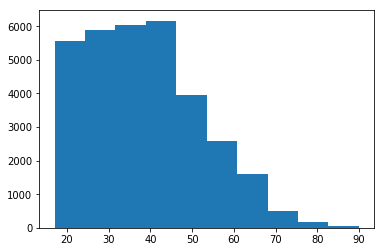

In [4]:
# The following histogram shows that age distribution is highly biased
plt.hist(adultWage['age'])
plt.show()

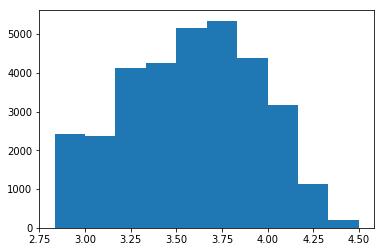

In [5]:
# log transforming these values would make their Euclidean distances to other features more uniform, which helps some classifiers.
adultWage['log-age'] = np.log(adultWage['age'])
plt.hist(adultWage['log-age'])
plt.show()

### education-num

In [6]:
# The education-num values provided show incremental behaviour, but
# it is natural to think that HS-grad (9) should be further away from 12th (8), because
# high school diploma can be a major factor on yearly income.
# We'll change weights if education-num > 8
educ_num_scale = 2
adultWage['education-num'] = adultWage['education-num'].map(lambda num:
                                                                num * educ_num_scale
                                                                if num > 8
                                                                else num)

### capital-gain and capital-loss

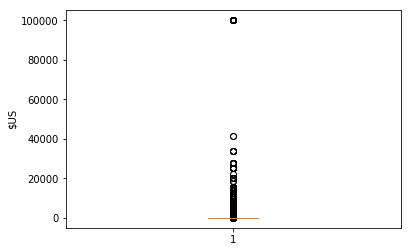

In [7]:
# the following boxplot shows that capital-gain is distributed in pareto distribution. 
plt.boxplot(adultWage['capital-gain'])
plt.ylabel('$US')
plt.show()

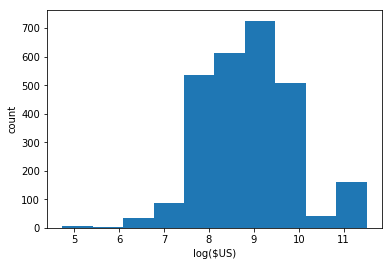

In [8]:
# log transforming these values would make their Euclidean distances to other features more sensible, which helps some classifiers.
adultWage['capital-gain'] = np.add(adultWage['capital-gain'], 0.00001)
adultWage['log-capital-gain'] = np.log(adultWage['capital-gain'])

# rank transforming will have a similar effect.
adultWage['rank-capital-gain'] = adultWage['capital-gain'].rank()

# plot a histogram of non-zero capital gain values to see how they are distributed
plt.hist(adultWage[adultWage['log-capital-gain'] > 1]['log-capital-gain'])
plt.xlabel('log($US)')
plt.ylabel('count')
plt.show()

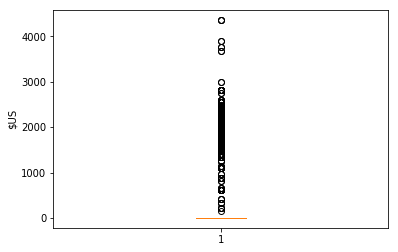

In [9]:
# the following boxplot shows that capital-gain is distributed in near-pareto distribution. 
plt.boxplot(adultWage['capital-loss'])
plt.ylabel('$US')
plt.show()

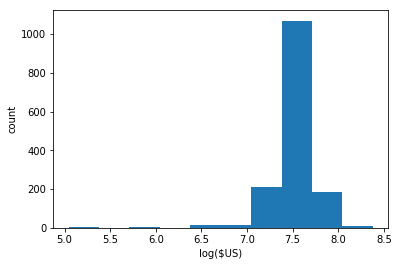

In [10]:
# log transforming these values would make their Euclidean distances to other features more sensible, which helps some classifiers.
adultWage['capital-loss'] = np.add(adultWage['capital-loss'], 0.00001)
adultWage['log-capital-loss'] = np.log(adultWage['capital-loss'])

# rank transforming will have a similar effect.
adultWage['rank-capital-loss'] = adultWage['capital-loss'].rank()

# plot a histogram of non-zero capital gain values to see how they are distributed
plt.hist(adultWage[adultWage['log-capital-loss'] > 1]['log-capital-loss'])
plt.xlabel('log($US)')
plt.ylabel('count')
plt.show()

## 2. Converting Categorical Data to Dummy Variables

### workclass

In [11]:
wc_dummies = pd.get_dummies(adultWage['workclass'])
#remove spaces in naming
wc_dummies.columns = wc_dummies.columns.str.replace(' ', '')

wcd_sums = wc_dummies.sum(axis = 0)
print(wcd_sums)

wc_dummies

?                    1836
Federal-gov           960
Local-gov            2093
Never-worked            7
Private             22696
Self-emp-inc         1116
Self-emp-not-inc     2541
State-gov            1298
Without-pay            14
dtype: int64


,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0
6,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,1,0,0
8,0,0,0,0,1,0,0,0,0
9,0,0,0,0,1,0,0,0,0


In [12]:
# we want to avoid tables that are too sparsely populated - sarse matrix results in overfitting. 
# Remove and combine variables accordingly to remove low-count dummy variables as much as possible.
wc_dummies['Workclass_others'] = wc_dummies['?'] + wc_dummies['Never-worked'] + wc_dummies['Without-pay'];
wc_dummies_final = wc_dummies.drop(columns = ['?', 'Never-worked', 'Without-pay'])

wcd_sums2 = wc_dummies_final.sum(axis = 0)
print(wcd_sums2)

Federal-gov           960
Local-gov            2093
Private             22696
Self-emp-inc         1116
Self-emp-not-inc     2541
State-gov            1298
Workclass_others     1857
dtype: int64


### marital-status

In [13]:
ms_dummies = pd.get_dummies(adultWage['marital-status'])
#remove spaces in naming
ms_dummies.columns = ms_dummies.columns.str.replace(' ', '')

msd_sums = ms_dummies.sum(axis = 0)
print(msd_sums)

ms_dummies

Divorced                  4443
Married-AF-spouse           23
Married-civ-spouse       14976
Married-spouse-absent      418
Never-married            10683
Separated                 1025
Widowed                    993
dtype: int64


,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
5,0,0,1,0,0,0,0
6,0,0,0,1,0,0,0
7,0,0,1,0,0,0,0
8,0,0,0,0,1,0,0
9,0,0,1,0,0,0,0


In [14]:
# we want to avoid tables that are too sparsely populated - sarse matrix results in overfitting. 
# Remove and combine variables accordingly to remove low-count dummy variables as much as possible.

ms_dummies['Married'] = ms_dummies['Married-AF-spouse'] +  ms_dummies['Married-civ-spouse'];
ms_dummies_final = ms_dummies.drop(columns = ['Married-AF-spouse', 'Married-civ-spouse'])

msd_sums2 = ms_dummies_final.sum(axis = 0)
print(msd_sums2)


Divorced                  4443
Married-spouse-absent      418
Never-married            10683
Separated                 1025
Widowed                    993
Married                  14999
dtype: int64


### occupation

In [15]:
occ_dummies = pd.get_dummies(adultWage['occupation'])
#remove spaces in naming
occ_dummies.columns = occ_dummies.columns.str.replace(' ', '')

occd_sums = occ_dummies.sum(axis = 0)
print(occd_sums)

occ_dummies

?                    1843
Adm-clerical         3770
Armed-Forces            9
Craft-repair         4099
Exec-managerial      4066
Farming-fishing       994
Handlers-cleaners    1370
Machine-op-inspct    2002
Other-service        3295
Priv-house-serv       149
Prof-specialty       4140
Protective-serv       649
Sales                3650
Tech-support          928
Transport-moving     1597
dtype: int64


,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [16]:
occ_dummies['Occupation-others'] = occ_dummies['?'] + occ_dummies['Armed-Forces'] + occ_dummies['Priv-house-serv']
occ_dummies_final = occ_dummies.drop(columns = ['?', 'Armed-Forces', 'Priv-house-serv'])

occd_sums2 = occ_dummies_final.sum(axis = 0)
print(occd_sums2)


Adm-clerical         3770
Craft-repair         4099
Exec-managerial      4066
Farming-fishing       994
Handlers-cleaners    1370
Machine-op-inspct    2002
Other-service        3295
Prof-specialty       4140
Protective-serv       649
Sales                3650
Tech-support          928
Transport-moving     1597
Occupation-others    2001
dtype: int64


### relationship

In [17]:
rel_dummies = pd.get_dummies(adultWage['relationship'])
#remove spaces in naming
rel_dummies.columns = rel_dummies.columns.str.replace(' ', '')

reld_sums = rel_dummies.sum(axis = 0)
print(reld_sums)

rel_dummies

Husband           13193
Not-in-family      8305
Other-relative      981
Own-child          5068
Unmarried          3446
Wife               1568
dtype: int64


,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,1
5,0,0,0,0,0,1
6,0,1,0,0,0,0
7,1,0,0,0,0,0
8,0,1,0,0,0,0
9,1,0,0,0,0,0


### race

In [18]:
r_dummies = pd.get_dummies(adultWage['race'])
#remove spaces in naming
r_dummies.columns = r_dummies.columns.str.replace(' ', '')

rd_sums = r_dummies.sum(axis = 0)
print(rd_sums)

r_dummies

Amer-Indian-Eskimo      311
Asian-Pac-Islander     1039
Black                  3124
Other                   271
White                 27816
dtype: int64


,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,1,0,0
4,0,0,1,0,0
5,0,0,0,0,1
6,0,0,1,0,0
7,0,0,0,0,1
8,0,0,0,0,1
9,0,0,0,0,1


In [19]:
r_dummies['Other'] = r_dummies['Other'] + r_dummies['Amer-Indian-Eskimo']
r_dummies_final = r_dummies.drop(columns = ['Amer-Indian-Eskimo'])
rd_sums = r_dummies_final.sum(axis = 0)
print(rd_sums)

Asian-Pac-Islander     1039
Black                  3124
Other                   582
White                 27816
dtype: int64


### sex

In [20]:
s_dummies = pd.get_dummies(adultWage['sex'])
#remove spaces in naming
s_dummies.columns = s_dummies.columns.str.replace(' ', '')

sd_sums = s_dummies.sum(axis = 0)
print(sd_sums)

s_dummies

Female    10771
Male      21790
dtype: int64


,Female,Male
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0
5,1,0
6,1,0
7,0,1
8,1,0
9,0,1


## 3. Combining Data

In [21]:
dummies = pd.concat([wc_dummies_final, ms_dummies_final, occ_dummies_final, rel_dummies, r_dummies_final, s_dummies], axis=1, sort=False)
numericals = pd.concat([adultWage['y'],adultWage['log-age'],adultWage['education-num'],adultWage['log-capital-gain'],adultWage['log-capital-loss']], axis=1, sort=False)
#[adultWage['y'],adultWage['fnlwgt'],adultWage['age'],adultWage['education-num'],adultWage['capital-gain'],adultWage['capital-loss']


df = pd.concat([numericals, dummies], axis=1)
df

,y,log-age,education-num,log-capital-gain,log-capital-loss,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,...,Other-relative,Own-child,Unmarried,Wife,Asian-Pac-Islander,Black,Other,White,Female,Male
0,<=50K,3.663562,26,7.684324,-11.512925,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,<=50K,3.912023,26,-11.512925,-11.512925,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,<=50K,3.637586,18,-11.512925,-11.512925,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
3,<=50K,3.970292,7,-11.512925,-11.512925,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,<=50K,3.332205,26,-11.512925,-11.512925,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
5,<=50K,3.610918,28,-11.512925,-11.512925,0,0,1,0,0,...,0,0,0,1,0,0,0,1,1,0
6,<=50K,3.891820,5,-11.512925,-11.512925,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
7,>50K,3.951244,18,-11.512925,-11.512925,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
8,>50K,3.433987,28,9.552795,-11.512925,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
9,>50K,3.737670,26,8.552174,-11.512925,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1


# ML MODELS

In [22]:
y = df['y']
# Print the ratio of categories to observe imbalance in our predicted variable
print(y.value_counts()/y.count())

# TODO: potentially oversampling/undersampling to even out the ratio.

 <=50K    0.75919
 >50K     0.24081
Name: y, dtype: float64


In [23]:
# Data Sampling:
# Ratio of <=50K to >50K is roughly 3:1. We'll balance the ratio with sample_ratio
y_over_50K = df[df['y'].map(lambda income: income == ' >50K')]
y_under_50K = df[df['y'].map(lambda income: income == ' <=50K')]

sample_ratio = 1
sample_length = int(len(y_over_50K) * sample_ratio)
y_under_50K_sampled = y_under_50K.sample(n=sample_length)

df_new = pd.concat([y_under_50K_sampled, y_over_50K])

In [24]:
# Prepare values. Play around with these categories to find the best fit
y = df_new['y']
X = df_new.drop(columns=['y']).astype('float')
trainedFeatures = list(X)

X

,log-age,education-num,log-capital-gain,log-capital-loss,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,...,Other-relative,Own-child,Unmarried,Wife,Asian-Pac-Islander,Black,Other,White,Female,Male
20443,3.135494,20.0,-11.512925,-11.512925,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
23238,3.663562,18.0,8.831858,-11.512925,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8661,3.610918,20.0,-11.512925,-11.512925,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
21757,3.258097,20.0,-11.512925,-11.512925,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
28644,3.135494,26.0,-11.512925,-11.512925,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9296,3.555348,24.0,-11.512925,-11.512925,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
21310,3.044522,22.0,-11.512925,-11.512925,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
30990,3.496508,18.0,-11.512925,-11.512925,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
12773,3.178054,20.0,-11.512925,-11.512925,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6715,3.688879,8.0,-11.512925,-11.512925,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [25]:
# Bayesian model
n = 50
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    bayes_model = GaussianNB()
    bayes_model.fit(X_train, y_train)
    totalTrain += bayes_model.score(X_train, y_train)
    totalValid += bayes_model.score(X_valid, y_valid)
    array.append(bayes_model.score(X_valid, y_valid))

bayesTrainScore = totalTrain/n
bayesValidScore = totalValid/n
print("training: " + str(bayesTrainScore))
print("validation: " + str(bayesValidScore))

training: 0.7818178726298787
validation: 0.7813108900790613


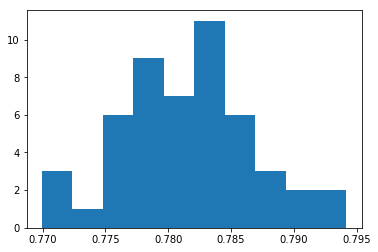

In [26]:
#lets see what the distribution of the scores look like
plt.hist(array)
plt.show()

In [27]:
# k-nearest neighbours (scaled)
n_nbs = 8
n = 5
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    knn_model = make_pipeline(
        MinMaxScaler(),
        PCA(15),
        KNeighborsClassifier(n_neighbors=n_nbs)
        )
    knn_model.fit(X_train, y_train)
    totalTrain += knn_model.score(X_train, y_train)
    totalValid += knn_model.score(X_valid, y_valid)
    array.append(knn_model.score(X_valid, y_valid))

knnTrainScore = totalTrain/n
knnValidScore = totalValid/n    
print("training: " + str(knnTrainScore))
print("validation: " + str(knnValidScore))

training: 0.8268004421392738
validation: 0.7860749808722265


In [28]:
# Support Vector machine

n = 1
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    svm_model = make_pipeline(
        MinMaxScaler(),
        PCA(10),
        SVC(kernel='rbf', C=6, gamma='scale', decision_function_shape='ovr')
        )
    svm_model.fit(X_train, y_train)
    totalTrain += svm_model.score(X_train, y_train)
    totalValid += svm_model.score(X_valid, y_valid)    

svmTrainScore = totalTrain/n
svmValidScore = totalValid/n    
print("training: " + str(svmTrainScore))
print("validation: " + str(svmValidScore))

training: 0.8084346569169288
validation: 0.7992858964549859


In [29]:
# Neural Network

n = 3
totalTrain = 0
totalValid = 0
array = []
for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    neural_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(35,25), activation='logistic')
    neural_model.fit(X_train, y_train)
    totalTrain += neural_model.score(X_train, y_train)
    totalValid += neural_model.score(X_valid, y_valid)    

neuralTrainScore = totalTrain/n
neuralValidScore = totalValid/n    
print("training: " + str(neuralTrainScore))
print("validation: " + str(neuralValidScore))

training: 0.8205368024260976
validation: 0.8200289041911076


In [30]:
# Gradient Boosting Tree Classifier

n = 3
totalTrain = 0
totalValid = 0

# Tweak around these parameters to find the optimal one. 
n_estim = 30
max_dep = 15
min_samples = 30

for i in range(n):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    gb_model = GradientBoostingClassifier(n_estimators=n_estim, max_depth=max_dep, min_samples_leaf=min_samples)    
    gb_model.fit(X_train, y_train)
    totalTrain += gb_model.score(X_train, y_train)
    totalValid += gb_model.score(X_valid, y_valid)    

gbTrainScore = totalTrain/n
gbValidScore = totalValid/n    
print("n_estim=" + str(n_estim) + ", max_dep=" + str(max_dep) + ", min_samples=" + str(min_samples))
print("training: " + str(gbTrainScore))
print("validation: " + str(gbValidScore))

n_estim=30, max_dep=15, min_samples=30
training: 0.8541507241447723
validation: 0.832015642268129


In [31]:
#Use this code if recomputing the baseline values

print("Features used to train model:\n" + str(trainedFeatures) + "\n")
print ("Bayes: %.3f" % bayesTrainScore + " %.3f" % bayesValidScore)
print ("knn: %.3f" % knnTrainScore + " %.3f" % knnValidScore)
print ("SVM: %.3f" % svmTrainScore + " %.3f" % svmValidScore)
print ("neural: %.3f" % neuralTrainScore + " %.3f" % neuralValidScore)
print ("Gradient Boost: %.3f" % gbTrainScore + " %.3f" % gbValidScore)

Features used to train model:
['log-age', 'education-num', 'log-capital-gain', 'log-capital-loss', 'Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Workclass_others', 'Divorced', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed', 'Married', 'Adm-clerical', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving', 'Occupation-others', 'Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife', 'Asian-Pac-Islander', 'Black', 'Other', 'White', 'Female', 'Male']

Bayes: 0.782 0.781
knn: 0.827 0.786
SVM: 0.808 0.799
neural: 0.821 0.820
Gradient Boost: 0.854 0.832
